## Running Simple Difference Between Two .hic Samples

* Data is from [DLBCL](https://en.wikipedia.org/wiki/Diffuse_large_B-cell_lymphoma)
* CHESS documentation was referenced for this experiment: https://chess-hic.readthedocs.io/en/latest/example_analysis.html

### Imports & Function Delcarations

Imports and functions are from original [chess repo](https://github.com/vaquerizaslab/chess/blob/master/examples/dlbcl/example_analysis.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def highlight_features(dataframe, region, color, a, axes):
    try:
        features = dataframe.loc[region].values.tolist()
        if type(features[0]) == int:
            _, x_min, x_max, y_min, y_max = features
            rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                     edgecolor=color, facecolor='none')
            axes[a].add_patch(rect)
        else:
            for f in features:
                _, x_min, x_max, y_min, y_max = f
                rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                         edgecolor=color, facecolor='none')
                axes[a].add_patch(rect)
                
    except KeyError:
        next

### Load .hic Files

In [3]:
winsize = "3mb"
wdir = "./"
region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

gained = pd.read_csv(wdir + 'gained_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])
lost = pd.read_csv(wdir + 'lost_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])

regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

reg = 1448

window_start, window_end = regions.loc[reg][1:3]

region_string = "chr2:{}-{}".format(window_start, window_end)

patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v

### Generate Plots
Toggle the `PATIENT_FIRST` variable below to generate one of the following plots described below:

#### Patient - Control Plot
Represents what features the patient has that was not found in the control. Thus, isolating the **gained** features.

#### Control - Patient Plot
Represents what features the control has that was not found in the patient. Thus, isolating the **lost** features.

Notes:
* Plotting original HiC data for patient and control on first row
* Simple diff and chess calculation plot on second row

* Feature detection boxes are generated with methods from original chess paper
* Red boxes in feature highlighting represent gained detected TAD structures
* Blue boxes are lost features

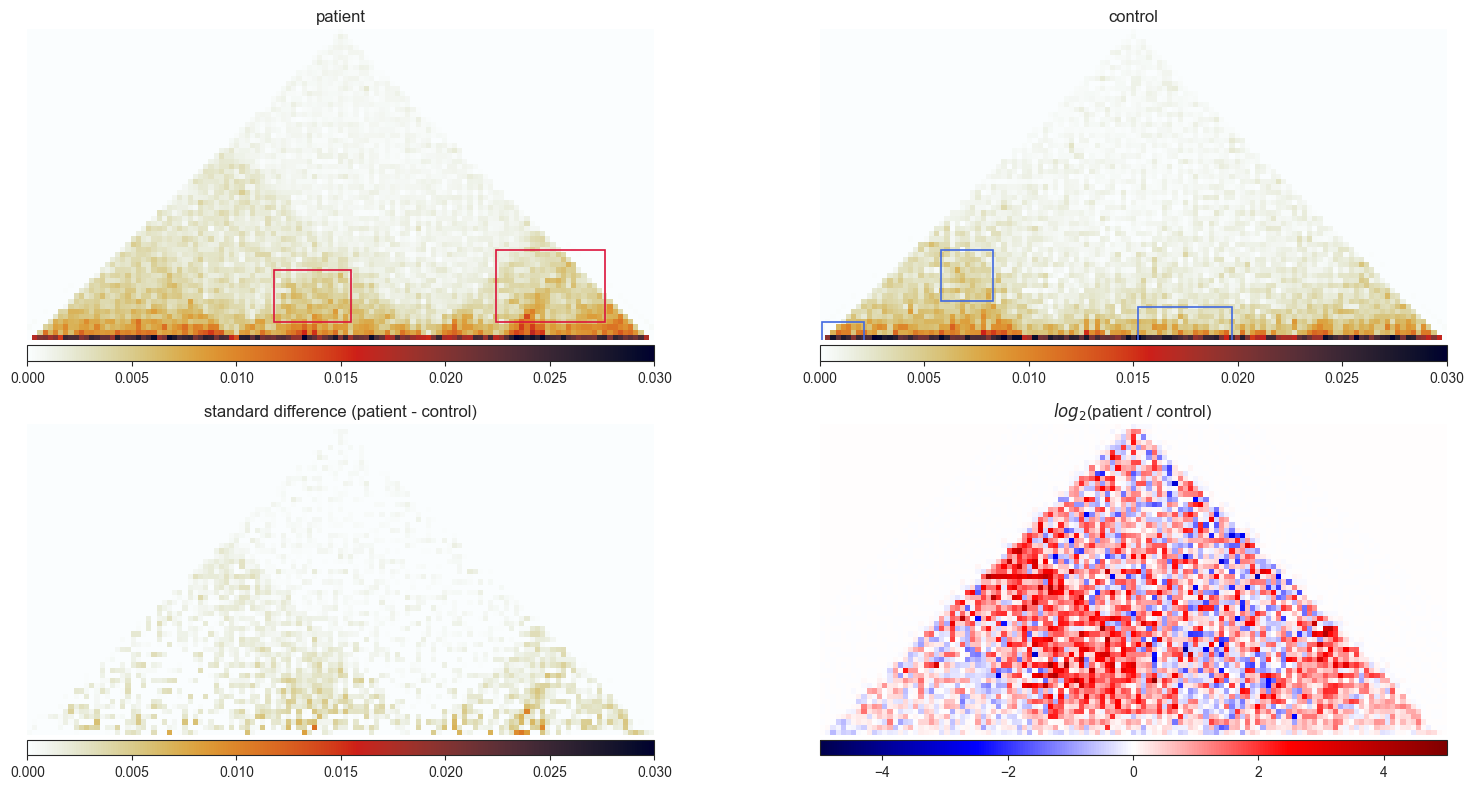

In [4]:
PATIENT_FIRST = True # toggle to do patient - control or vice versa for simple diff calculation

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# ----- plotting original hic sample -----
axes[0][0].set_title('patient')
axes[0][1].set_title('control')

# clipped zoom and rotate patient and control and keep only half-matrix
zm1 = clipped_zoom(control_region_sub, 0.7)
rot_control = ndi.rotate(zm1, 45, reshape=False)

zm2 = clipped_zoom(patient_region_sub, 0.7)
rot_patient = ndi.rotate(zm2, 45, reshape=False)

middle = int(np.shape(rot_control)[1]/ 2.)

m1 = axes[0][0].imshow(rot_patient[:middle, :], vmin=0, vmax=0.03, cmap='germany')
m2 = axes[0][1].imshow(rot_control[:middle,:], vmin=0, vmax=0.03, cmap='germany')

# per region check if identified features, to highlight
highlight_features(gained, reg, 'crimson', 0, axes[0])
highlight_features(lost, reg, 'royalblue', 1, axes[0])


# ----- plotting simple diff and chess calc -----
axes[1][1].set_title('$log_2$(patient / control)')

# Standard diff calculation to compare against
if PATIENT_FIRST:
    diff = patient_region_sub - control_region_sub
    axes[1][0].set_title('standard difference (patient - control)')
else:
    diff = control_region_sub - patient_region_sub
    axes[1][0].set_title('standard difference (control - patient)')
clipped = clipped_zoom(diff, 0.7)
diff_plot = ndi.rotate(clipped, 45, reshape=False)

# patient - control standard diff 
m3 = axes[1][0].imshow(diff_plot[:middle,:], vmin=0, vmax=0.03, cmap='germany')

# patient / control calculation from chess paper
l2fcm = np.log2(patient_region_sub / control_region_sub)
zml2 = clipped_zoom(l2fcm, 0.7)
rot_l2 = ndi.rotate(zml2, 45, reshape=False)

# original log(patient/control) calc plot from chess
m4 = axes[1][1].imshow(rot_l2[:middle,:], cmap='seismic', vmax=5, vmin=-5)

for m, ax in zip([m1, m2], axes[0]):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    fig.colorbar(m, cax=cax, orientation='horizontal')

for m, ax in zip([m3, m4], axes[1]):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    fig.colorbar(m, cax=cax, orientation='horizontal')

plt.tight_layout()